In [1]:
# set automitic module reload. Useful when you are editing external python files
%load_ext autoreload   
%autoreload 2

%pylab inline

from lib.KDTreeEncoding import *

import xgboost as xgb
from lib.XGBHelper import *
from lib.XGBoost_params import *
from lib.score_analysis import *

from lib.logger import logger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import load
from glob import glob
import pandas as pd
import pickle as pkl

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [17]:
poverty_dir='/Users/yoavfreund/datasets/poverty_v1.1/'
image_dir=poverty_dir+'anon_images/'
#use the following line when running on datahub
#poverty_dir = '/dsmlp/datasets/cs255-sp22-a00-public/poverty/'
depth=8   #for KDTree

### Files to submit

results.csv — your predictions on the random test set

results_country.csv — your predictions on the country test set

code.zip — your code in a zip file

### columns in the .csv files
filename — e.g. image13724.npz

urban — 1 when urban, 0 when not urban

label — predictions of -1, 1, and 0 when I don’t know

label_accuracy - predictions of -1, 1

In [4]:
!ls -lh data/

total 24560
-rw-r--r--  1 yoavfreund  staff   4.6M May 25 12:00 DumpNoSplit.pk
-rw-r--r--  1 yoavfreund  staff   3.9M May 25 12:00 DumpRural.pk
-rw-r--r--  1 yoavfreund  staff   3.4M May 25 12:00 DumpUrban.pk


In [29]:
import pickle as pkl
pkl_file='data/DumpNoSplit.pk'
D=pkl.load(open(pkl_file,'rb'))
# ['styled_logs', 'tree', 'mean', 'std']
for k in D:
    globals()[k]=D[k]
scaling_mean=mean
scaling_std=std

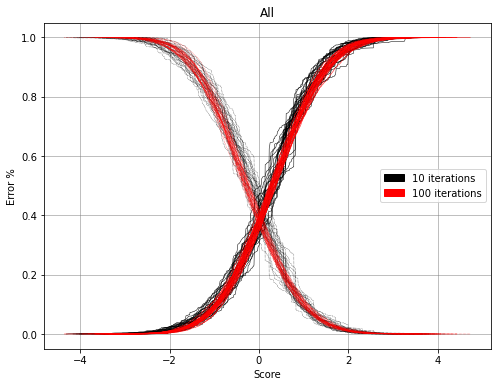

In [6]:
_mean,_std=plot_scores(styled_logs,title='All')

In [21]:
bst_list=[x['bst'] for x in styled_logs[1]['log']]

### Iterate over test sets

In [22]:
folds=[{'in':'country_test_reduct.csv','out':'results_country.csv'},
      {'in':'random_test_reduct.csv','out':'results.csv'}]

In [89]:
%%writefile generate_predictions.py
for fold_i in range(len(folds)):
    fold=folds[fold_i]

    #load table entries
    test_csv=f'../public_tables/{fold["in"]}'

    test=pd.read_csv(test_csv,index_col=0)
    test.index=test['filename']
    test.shape

    out=pd.DataFrame()
    out.index=test.index
    out['label']=0
    out['urban']=test['urban']

    ## Encode all data using encoding tree
    Enc_data=encoded_dataset(image_dir,out,tree,label_col='label')

    data=to_DMatrix(Enc_data.data)
    Preds=zeros([Enc_data.data.shape[0],len(bst_list)])
    for i in range(len(bst_list)):
        Preds[:,i]=bst_list[i].predict(data,output_margin=True)
    Preds=(Preds-scaling_mean)/scaling_std # apply overall score scaling

    _mean=np.mean(Preds,axis=1)
    _std=np.std(Preds,axis=1)

    pred_wo_abstention=(2*(_mean>0))-1
    pred_with_abstention=copy(pred_wo_abstention)
    pred_with_abstention[_std>abs(_mean)]=0

    out['label'] = pred_with_abstention
    out['label_accuracy'] = pred_wo_abstention


    outFile=f'data/{fold["out"]}'
    out.to_csv(outFile)
    print('\n\n'+'-'*60)
    print(outFile)
    !head $outFile

Writing generate_predictions.py


In [86]:
!ls

4x4MileAquareAroundUCSD.png __init__.py                 lib
Make-Predictions.ipynb      browse images.ipynb         old
No-abstain.ipynb            data                        preliminary analysis.ipynb


In [ ]:
figure(figsize=[12,10])
_median=np.median(Preds,axis=1)
scatter(_mean,_std,s=1);
grid()

In [ ]:
hist(_mean,bins=100);

### Train and test

In [ ]:
# set parameters for XGBoost
param['max_depth']=2
param['num_round']=10
param

### Train on random split, urban and rural together

In [ ]:
%%time
train_selector=np.random.rand(df.shape[0]) > 0.7
Train=D.get_subset(train_selector)
Test=D.get_subset(~train_selector)

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['k:','k-'],
        'label':'10 iterations',
        'label_color':'k'
    },
    {   'log':log100,
        'style':['r:','r-'],
        'label':'100 iterations',
        'label_color':'r'
    }
]
_mean,_std=plot_scores(styled_logs,title='All')

pickle_file=f'data/DumpNoSplit.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file

## Train on Urban only
Random split into train and test.

In [ ]:
%%time
urban=True
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.7
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['g:','g-'],
        'label':'10 iterations',
        'label_color':'g'
    },
    {   'log':log100,
        'style':['b:','b-'],
        'label':'100 iterations',
        'label_color':'b'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file

## Train on Rural only
Random split into train and test.

In [ ]:
urban=False
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.7
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['y:','y-'],
        'label':'10 iterations',
        'label_color':'y'
    },
    {   'log':log100,
        'style':['m:','m-'],
        'label':'100 iterations',
        'label_color':'m'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file